In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
from google.colab import files
from google.colab import drive

import os
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.ticker
plt.rcParams['figure.figsize'] = (10,8)

from sklearn.utils import class_weight
from PIL import Image

import tensorflow.keras
from tensorflow.keras import utils
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.models import  load_model,Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization, Conv2D , MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.applications import *
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import *


In [4]:
uploaded = files.upload()

Saving artists.csv to artists.csv


In [3]:
df=pd.read_csv('artists.csv')
df.head()

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194


In [4]:
painters = df[['name','paintings']]
painters = painters.sort_values(by='paintings', ascending=False)
painters.head()

,name,paintings
8,Vincent van Gogh,877
30,Edgar Degas,702
13,Pablo Picasso,439
15,Pierre-Auguste Renoir,336
19,Albrecht Dürer,328


In [5]:
painters=painters[painters['paintings']>=80].reset_index()
painters

,index,name,paintings
0,8,Vincent van Gogh,877
1,30,Edgar Degas,702
2,13,Pablo Picasso,439
3,15,Pierre-Auguste Renoir,336
4,19,Albrecht Dürer,328
5,46,Paul Gauguin,311
6,16,Francisco Goya,291
7,31,Rembrandt,262
8,20,Alfred Sisley,259
9,32,Titian,255


In [6]:
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [7]:
images = '/gdrive/My Drive/images'

In [8]:
painters_dir=os.listdir(images)

In [9]:
painters_name = painters['name'].str.replace(' ','_')

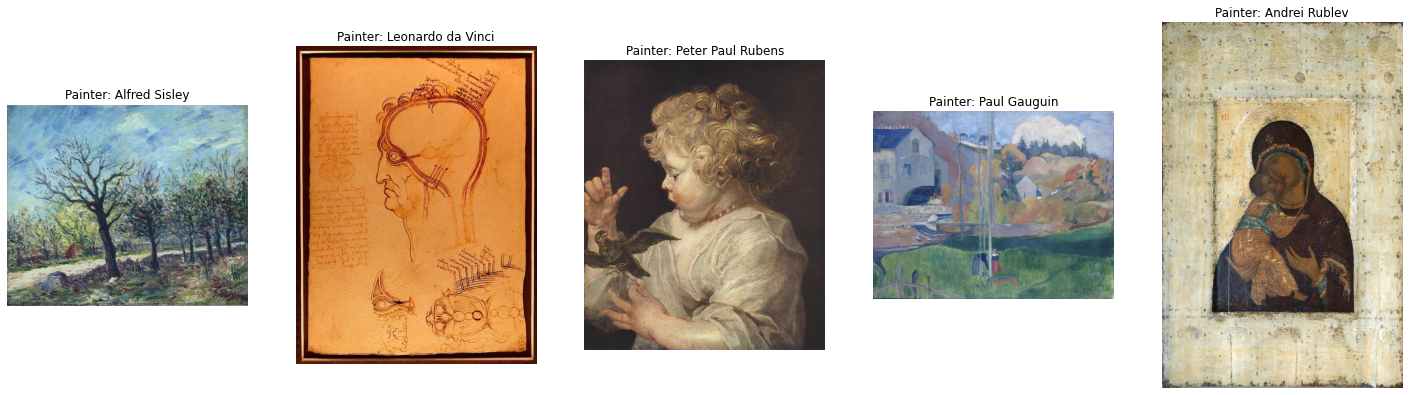

In [10]:
n= 5
fig, axes = plt.subplots(1,n, figsize=(25,18))

for i in range(n):
    painter_random = random.choice(painters_name)
    painting_random = random.choice(os.listdir(os.path.join(images,painter_random)))
    painting_file_random = os.path.join(images,painter_random,painting_random)
    painting=plt.imread(painting_file_random)
    axes[i].imshow(painting)
    axes[i].set_title('Painter: ' + painter_random.replace('_',' '))
    axes[i].axis('off')
    
plt.show()

In [22]:
data_gen = ImageDataGenerator(#rotation_range=5, 
                              #width_shift_range=0.1, 
                              #height_shift_range=0.1, 
                              shear_range=0.5, 
                              zoom_range=0.2,
                              #fill_mode='nearest',
                              horizontal_flip=True,
                              vertical_flip=True,
                              rescale= 1./255.,
                              validation_split=0.2)

test_gen =ImageDataGenerator()

In [23]:
train_gen = data_gen.flow_from_directory(directory = images,
                                         classes = painters_name.tolist(),
                                         class_mode='categorical',
                                         batch_size=64,
                                         shuffle=True,
                                         subset='training',
                                         target_size=(224,224))

Found 6035 images belonging to 38 classes.


In [24]:
test_gen = data_gen.flow_from_directory(directory = images,
                                         classes = painters_name.tolist(),
                                         class_mode='categorical',
                                         batch_size=64,
                                         shuffle=True,
                                         subset='validation',
                                         target_size=(224,224))

Found 1492 images belonging to 38 classes.


In [25]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(train_gen.classes), train_gen.classes)

In [26]:
base_model = ResNet50(input_shape = (224, 224, 3), include_top = True,weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = True

In [27]:
x = base_model.output
x = Flatten()(x)
x = Dense(512, kernel_initializer= 'he_uniform')(x)
x = BatchNormalization()(x)
x = Activation ('relu')(x)

x = Dense(16, kernel_initializer= 'he_uniform')(x)
x = BatchNormalization()(x)
x = Activation ('relu')(x)

output = Dense(38, activation='softmax')(x)
model = Model(inputs= base_model.input , outputs = output)

In [28]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [29]:
optimizer = Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics = ['accuracy'])

In [30]:
early_stop = EarlyStopping(monitor='val_loss',
                           patience=15, 
                           mode='auto', 
                           restore_best_weights=True)

learning_rate = ReduceLROnPlateau(monitor='val_loss', 
                                 factor=0.1, 
                                 patience=15,
                                 mode='auto')

In [31]:
history = model.fit(train_gen,
                    epochs=45,
                    verbose =1, 
                    validation_steps=1492//64,
                    steps_per_epoch=6035//64,
                    callbacks=[learning_rate, early_stop], 
                    class_weight=class_weights, 
                    validation_data=test_gen, 
                    shuffle=True,
                    workers=15,
                    use_multiprocessing=True
                    )

Epoch 1/45
94/94 [==============================] - 222s 2s/step - loss: 3.5016 - acc: 0.1020 - val_loss: 3.6447 - val_acc: 0.0115
Epoch 2/45
94/94 [==============================] - 216s 2s/step - loss: 3.0919 - acc: 0.2696 - val_loss: 3.6580 - val_acc: 0.0163
Epoch 3/45
94/94 [==============================] - 217s 2s/step - loss: 2.8160 - acc: 0.4029 - val_loss: 3.6602 - val_acc: 0.0442
Epoch 4/45
94/94 [==============================] - 217s 2s/step - loss: 2.6187 - acc: 0.4832 - val_loss: 3.6545 - val_acc: 0.0401
Epoch 5/45
94/94 [==============================] - 217s 2s/step - loss: 2.5020 - acc: 0.5257 - val_loss: 3.6290 - val_acc: 0.0482
Epoch 6/45
94/94 [==============================] - 215s 2s/step - loss: 2.3680 - acc: 0.5736 - val_loss: 3.7029 - val_acc: 0.0537
Epoch 7/45
94/94 [==============================] - 215s 2s/step - loss: 2.2535 - acc: 0.6103 - val_loss: 3.5838 - val_acc: 0.0795
Epoch 8/45
94/94 [==============================] - 216s 2s/step - loss: 2.1863 - a

In [32]:
score = model.evaluate(train_gen, verbose=1)
print()
print('Training accuracy: ', score[1])

95/95 [==============================] - 173s 2s/step - loss: 0.4022 - acc: 0.9447

Training accuracy:  0.9446562


In [33]:
# testing the model
score = model.evaluate(test_gen, verbose=1)
print()
print('Test accuracy: ', score[1])

24/24 [==============================] - 42s 2s/step - loss: 1.5505 - acc: 0.6924

Test accuracy:  0.69235927


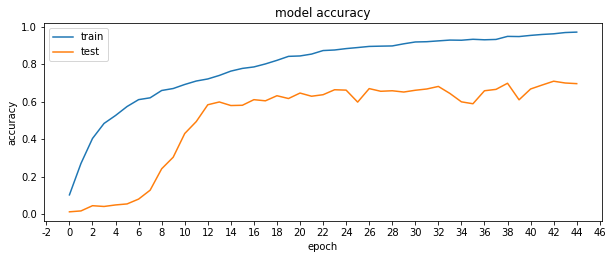

In [34]:
plt.rcParams['figure.figsize'] = (10,8)
plt.subplot(2,1,2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
locator = matplotlib.ticker.MultipleLocator(2)
plt.gca().xaxis.set_major_locator(locator)
formatter = matplotlib.ticker.StrMethodFormatter("{x:.0f}")
plt.gca().xaxis.set_major_formatter(formatter)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])

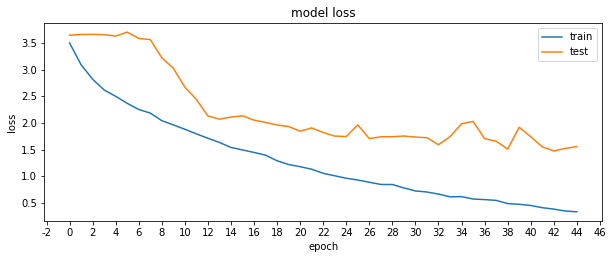

In [35]:
plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
locator = matplotlib.ticker.MultipleLocator(2)
plt.gca().xaxis.set_major_locator(locator)
formatter = matplotlib.ticker.StrMethodFormatter("{x:.0f}")
plt.gca().xaxis.set_major_formatter(formatter)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])

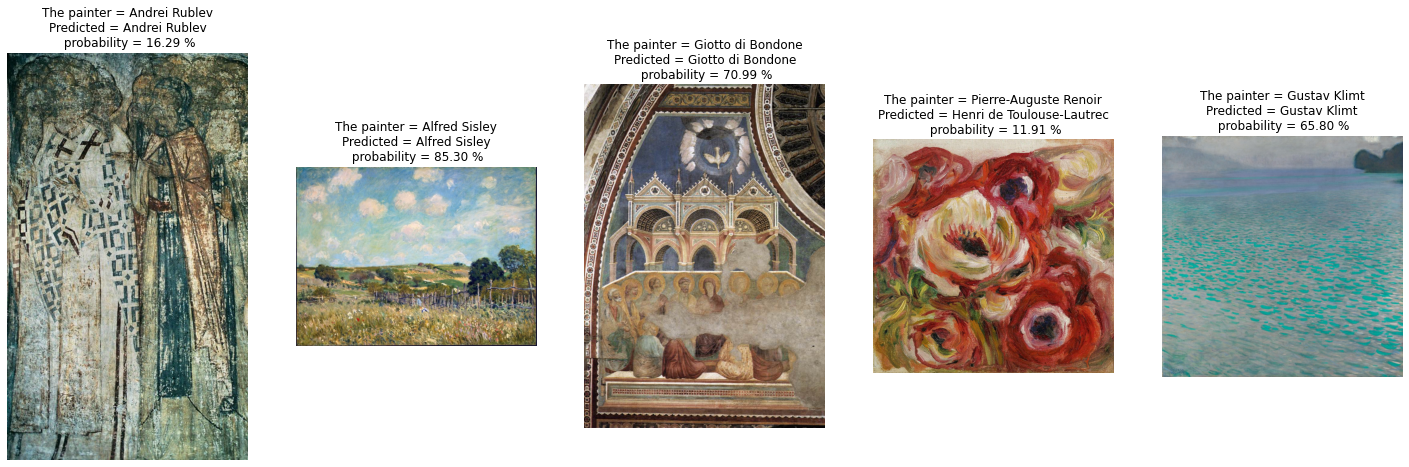

In [36]:
n = 5
fig, axes = plt.subplots(1, n, figsize=(25,10))

for i in range(n):
    painter_random = random.choice(painters_name)
    painting_random = random.choice(os.listdir(os.path.join(images, painter_random)))
    painting_file_random = os.path.join(images, painter_random, painting_random)

    test_image = Image.open(painting_file_random) 
    test_image = test_image.resize((224,224))

    test_image = np.array(test_image)
    test_image = test_image / 255.0
    test_image = np.expand_dims(test_image, axis=0)

    prediction = model.predict(test_image)
    pred_probability = np.amax(prediction)
    pred_idx = np.argmax(prediction)

    labels = train_gen.class_indices
    labels = dict((v,k) for k,v in labels.items())

    title = "The painter = {}\nPredicted = {}\n probability = {:.2f} %" \
                .format(painter_random.replace('_', ' '), labels[pred_idx].replace('_', ' '),
                        pred_probability*100)

    axes[i].imshow(plt.imread(painting_file_random))
    axes[i].set_title(title)
    axes[i].axis('off')

plt.show()

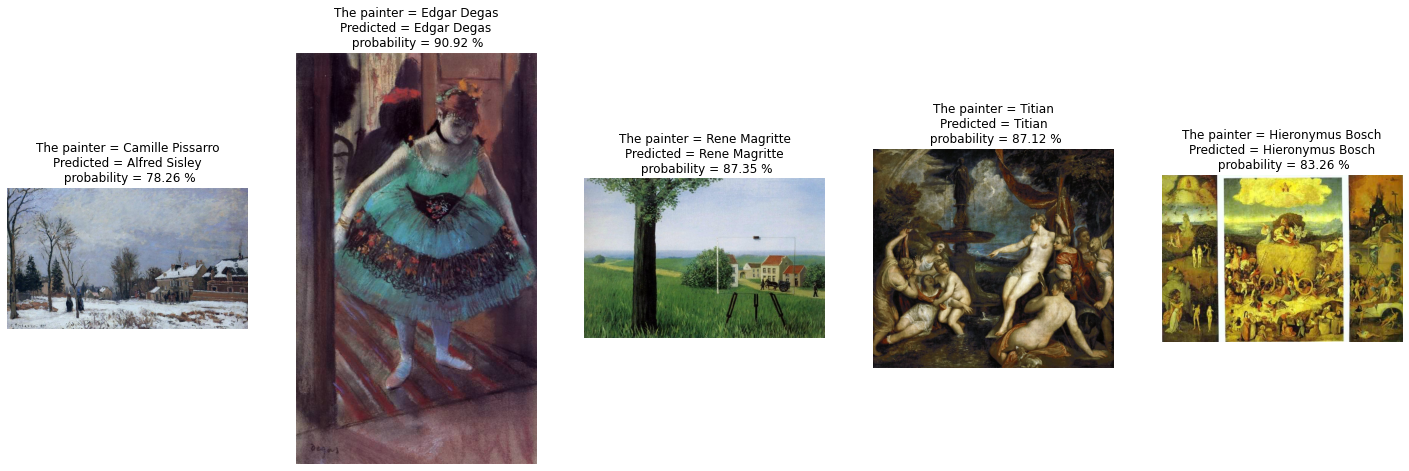

In [37]:
n = 5
fig, axes = plt.subplots(1, n, figsize=(25,10))

for i in range(n):
    painter_random = random.choice(painters_name)
    painting_random = random.choice(os.listdir(os.path.join(images, painter_random)))
    painting_file_random = os.path.join(images, painter_random, painting_random)

    test_image = Image.open(painting_file_random) 
    test_image = test_image.resize((224,224))

    test_image = np.array(test_image)
    test_image = test_image / 255.0
    test_image = np.expand_dims(test_image, axis=0)

    prediction = model.predict(test_image)
    pred_probability = np.amax(prediction)
    pred_idx = np.argmax(prediction)

    labels = train_gen.class_indices
    labels = dict((v,k) for k,v in labels.items())

    title = "The painter = {}\nPredicted = {}\n probability = {:.2f} %" \
                .format(painter_random.replace('_', ' '), labels[pred_idx].replace('_', ' '),
                        pred_probability*100)

    axes[i].imshow(plt.imread(painting_file_random))
    axes[i].set_title(title)
    axes[i].axis('off')

plt.show()